# RGBA vs One-Hot Encoded

In [1]:
import sys
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random


## Prepare Environment

In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # uncomment to run nb from 'pallets/nb'
# sys.path.append(os.path.abspath(os.getcwd()))                    # uncomment to run from project root

from pallets import images as I, datasets as DS, models as M, logging as L


In [3]:
USE_GPU = True
LOG_LEVEL = 'INFO'

TEST_SIZE = 1000
EPOCHS = 10
LR = 1e-03
BATCH_SIZE = 32


In [4]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL)


<Logger pallets (INFO)>

# Datasets

## RGBA Dataset

In [5]:
dataset_rgba = DS.CPunksDataset(test_size=TEST_SIZE)

train_sampler_rgba = SubsetRandomSampler(dataset_rgba.train_idx)
test_sampler_rgba = SubsetRandomSampler(dataset_rgba.test_idx)


INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../../cpunks-10k/cpunks/data/punks.json


## One Hot Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset_oh = DS.FastOneHotCPunksDataset(device, mapper, test_size=TEST_SIZE)

train_sampler_oh = SubsetRandomSampler(dataset_oh.train_idx)
test_sampler_oh = SubsetRandomSampler(dataset_oh.test_idx)


INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../../cpunks-10k/cpunks/data/punks.json


# Train All 4 Models

There are four autencoders. Two are based on RGBA colors and two are based on one-hot encoded colors.

* NaiveRGBAAutoencoder
* ConvRGBAAutoencoder
* NaiveOneHotAutoencoder
* ConvOneHotAutoencoder

Once each model is built, we will use the `graph_losses` and `view_reconstruction` functions to visualize their quality.

In [7]:
def graph_losses(train_losses, test_losses):
    plt.title("Train & Test loss")
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()


def view_reconstruction(model, data_loader):
    """
    Loads a punk from the data loader, reconstructs it with a trained model,
    then draws the punk below the cell where this is called.
    """
    punk, _ = next(iter(data_loader))
    reconstructed = model(punk.to(device))
    reconstructed = reconstructed.detach().cpu()
    some_image = reconstructed[22]

    # decode if one hot
    one_hot_models = (M.ae.NaiveOneHotAutoencoder, M.ae.ConvOneHotAutoencoder)
    if isinstance(model, one_hot_models):
        some_image = DS.one_hot_to_rgba(some_image, mapper)

    pil_image = to_pil_image(some_image.clone().detach())
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()


## Naive RGBA

In [8]:
model = M.ae.NaiveRGBAAutoencoder()
criterion = torch.nn.MSELoss()
train_loader = DataLoader(dataset_rgba, batch_size=BATCH_SIZE, sampler=train_sampler_rgba)
test_loader = DataLoader(dataset_rgba, batch_size=BATCH_SIZE, sampler=test_sampler_rgba)
save_name = 'ae.naive.rgba'

train_losses, test_losses = M.ae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(save_name, model, train_losses, test_losses)



INFO | model: pallets.models.ae.NaiveRGBAAutoencoder
INFO | criterion: torch.nn.modules.loss.MSELoss
INFO | learn rate: 0.001
INFO | epochs: 10
INFO | epoch 1 (  0%) loss: 0.111492
INFO | epoch 1 ( 35%) loss: 0.027003
INFO | epoch 1 ( 70%) loss: 0.019289
INFO | epoch 1 (100%) loss: 0.015960
INFO | epoch 1 (test) loss: 0.001669
INFO | epoch 2 (  0%) loss: 0.007316
INFO | epoch 2 ( 35%) loss: 0.005842
INFO | epoch 2 ( 70%) loss: 0.005211
INFO | epoch 2 (100%) loss: 0.004812
INFO | epoch 2 (test) loss: 0.000906
INFO | epoch 3 (  0%) loss: 0.003739
INFO | epoch 3 ( 35%) loss: 0.003357
INFO | epoch 3 ( 70%) loss: 0.003153
INFO | epoch 3 (100%) loss: 0.002997
INFO | epoch 3 (test) loss: 0.000638
INFO | epoch 4 (  0%) loss: 0.002095
INFO | epoch 4 ( 35%) loss: 0.002351
INFO | epoch 4 ( 70%) loss: 0.002264
INFO | epoch 4 (100%) loss: 0.002215
INFO | epoch 4 (test) loss: 0.000514
INFO | epoch 5 (  0%) loss: 0.002394
INFO | epoch 5 ( 35%) loss: 0.001935
INFO | epoch 5 ( 70%) loss: 0.001862
INFO 

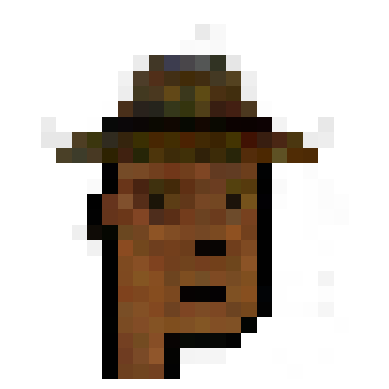

In [9]:
view_reconstruction(model, train_loader)

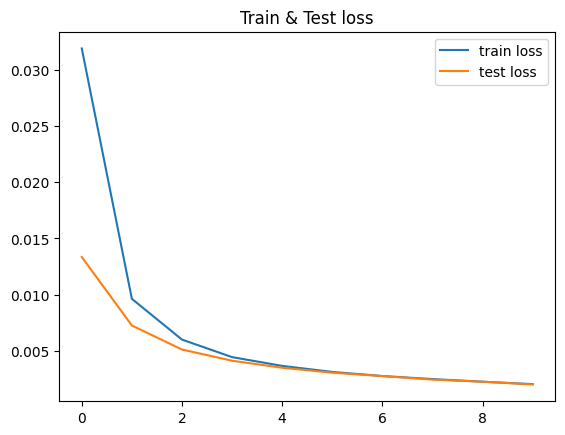

In [10]:
graph_losses(train_losses, test_losses)

## Conv RGBA

In [11]:
model = M.ae.ConvRGBAAutoencoder()
criterion = torch.nn.MSELoss()
train_loader = DataLoader(dataset_rgba, batch_size=BATCH_SIZE, sampler=train_sampler_rgba)
test_loader = DataLoader(dataset_rgba, batch_size=BATCH_SIZE, sampler=test_sampler_rgba)
save_name = 'ae.conv.rgba'

train_losses, test_losses = M.ae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(save_name, model, train_losses, test_losses)



INFO | model: pallets.models.ae.ConvRGBAAutoencoder
INFO | criterion: torch.nn.modules.loss.MSELoss
INFO | learn rate: 0.001
INFO | epochs: 10
INFO | epoch 1 (  0%) loss: 0.102316
INFO | epoch 1 ( 35%) loss: 0.018801
INFO | epoch 1 ( 70%) loss: 0.010600
INFO | epoch 1 (100%) loss: 0.007808
INFO | epoch 1 (test) loss: 0.000162
INFO | epoch 2 (  0%) loss: 0.000602
INFO | epoch 2 ( 35%) loss: 0.000571
INFO | epoch 2 ( 70%) loss: 0.000499
INFO | epoch 2 (100%) loss: 0.000449
INFO | epoch 2 (test) loss: 0.000074
INFO | epoch 3 (  0%) loss: 0.000262
INFO | epoch 3 ( 35%) loss: 0.000294
INFO | epoch 3 ( 70%) loss: 0.000270
INFO | epoch 3 (100%) loss: 0.000255
INFO | epoch 3 (test) loss: 0.000048
INFO | epoch 4 (  0%) loss: 0.000204
INFO | epoch 4 ( 35%) loss: 0.000203
INFO | epoch 4 ( 70%) loss: 0.000190
INFO | epoch 4 (100%) loss: 0.000184
INFO | epoch 4 (test) loss: 0.000037
INFO | epoch 5 (  0%) loss: 0.000176
INFO | epoch 5 ( 35%) loss: 0.000147
INFO | epoch 5 ( 70%) loss: 0.000144
INFO |

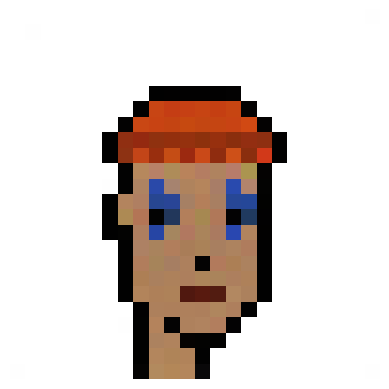

In [12]:
view_reconstruction(model, train_loader)

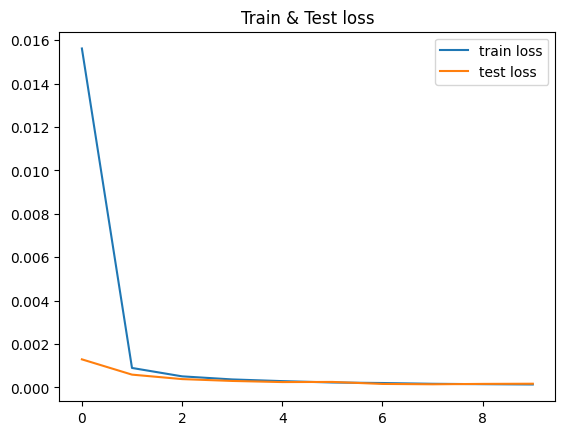

In [13]:
graph_losses(train_losses, test_losses)

## Naive One Hot

In [14]:
model = M.ae.NaiveOneHotAutoencoder()
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(dataset_oh, batch_size=BATCH_SIZE, sampler=train_sampler_oh)
test_loader = DataLoader(dataset_oh, batch_size=BATCH_SIZE, sampler=test_sampler_oh)
save_name = 'ae.naive.onehot'

train_losses, test_losses = M.ae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(save_name, model, train_losses, test_losses)



INFO | model: pallets.models.ae.NaiveOneHotAutoencoder
INFO | criterion: torch.nn.modules.loss.CrossEntropyLoss
INFO | learn rate: 0.001
INFO | epochs: 10
INFO | epoch 1 (  0%) loss: 2.703327
INFO | epoch 1 ( 35%) loss: 0.642619
INFO | epoch 1 ( 70%) loss: 0.438328
INFO | epoch 1 (100%) loss: 0.350931
INFO | epoch 1 (test) loss: 0.029084
INFO | epoch 2 (  0%) loss: 0.117710
INFO | epoch 2 ( 35%) loss: 0.086442
INFO | epoch 2 ( 70%) loss: 0.072885
INFO | epoch 2 (100%) loss: 0.065406
INFO | epoch 2 (test) loss: 0.010961
INFO | epoch 3 (  0%) loss: 0.039310
INFO | epoch 3 ( 35%) loss: 0.035981
INFO | epoch 3 ( 70%) loss: 0.033039
INFO | epoch 3 (100%) loss: 0.030908
INFO | epoch 3 (test) loss: 0.006842
INFO | epoch 4 (  0%) loss: 0.028138
INFO | epoch 4 ( 35%) loss: 0.021288
INFO | epoch 4 ( 70%) loss: 0.019785
INFO | epoch 4 (100%) loss: 0.018762
INFO | epoch 4 (test) loss: 0.004720
INFO | epoch 5 (  0%) loss: 0.015820
INFO | epoch 5 ( 35%) loss: 0.013668
INFO | epoch 5 ( 70%) loss: 0.0

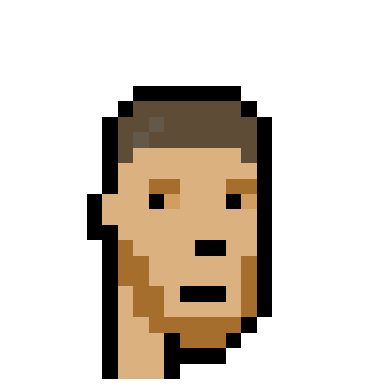

In [15]:
view_reconstruction(model, train_loader)

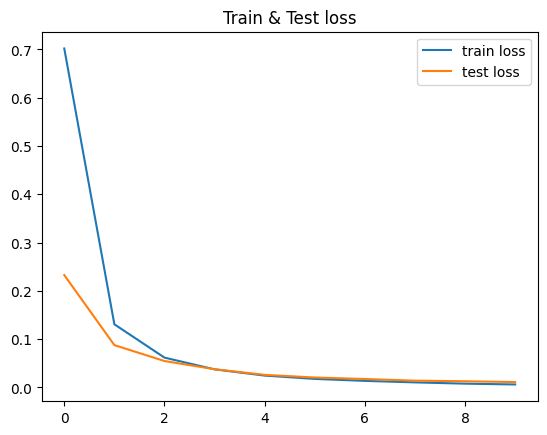

In [16]:
graph_losses(train_losses, test_losses)

## Conv One Hot

In [17]:
model = M.ae.ConvOneHotAutoencoder()
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(dataset_oh, batch_size=BATCH_SIZE, sampler=train_sampler_oh)
test_loader = DataLoader(dataset_oh, batch_size=BATCH_SIZE, sampler=test_sampler_oh)
save_name = 'ae.conv.onehot'

train_losses, test_losses = M.ae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(save_name, model, train_losses, test_losses)



INFO | model: pallets.models.ae.ConvOneHotAutoencoder
INFO | criterion: torch.nn.modules.loss.CrossEntropyLoss
INFO | learn rate: 0.001
INFO | epochs: 10
INFO | epoch 1 (  0%) loss: 2.705872
INFO | epoch 1 ( 35%) loss: 0.952971
INFO | epoch 1 ( 70%) loss: 0.630623
INFO | epoch 1 (100%) loss: 0.494235
INFO | epoch 1 (test) loss: 0.028836
INFO | epoch 2 (  0%) loss: 0.112175
INFO | epoch 2 ( 35%) loss: 0.069830
INFO | epoch 2 ( 70%) loss: 0.051294
INFO | epoch 2 (100%) loss: 0.042831
INFO | epoch 2 (test) loss: 0.004837
INFO | epoch 3 (  0%) loss: 0.015867
INFO | epoch 3 ( 35%) loss: 0.015901
INFO | epoch 3 ( 70%) loss: 0.013218
INFO | epoch 3 (100%) loss: 0.011792
INFO | epoch 3 (test) loss: 0.002058
INFO | epoch 4 (  0%) loss: 0.006515
INFO | epoch 4 ( 35%) loss: 0.005904
INFO | epoch 4 ( 70%) loss: 0.005342
INFO | epoch 4 (100%) loss: 0.004736
INFO | epoch 4 (test) loss: 0.000970
INFO | epoch 5 (  0%) loss: 0.003706
INFO | epoch 5 ( 35%) loss: 0.002534
INFO | epoch 5 ( 70%) loss: 0.00

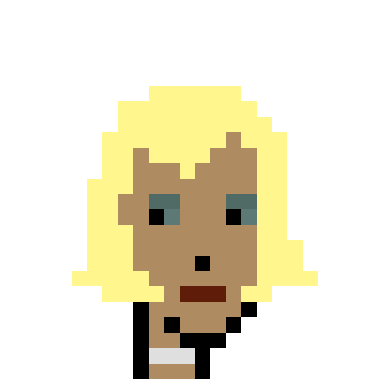

In [18]:
view_reconstruction(model, train_loader)

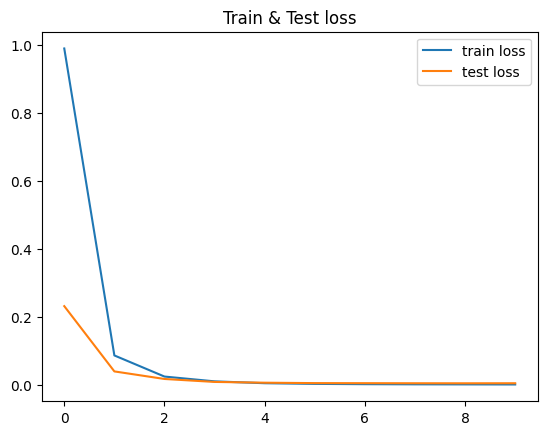

In [19]:
graph_losses(train_losses, test_losses)